In [24]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import sys
import os
from comet_ml import Experiment

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
sns.set_theme()

from ift6758.models.preprocessing import preprocess
from ift6758.models.plotter import *
from dotenv import load_dotenv


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
url = 'https://drive.google.com/file/d/1kM__riNHRPx5GsyuOH3yhiql3OZvwmuP/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
df = pd.read_csv(path)


In [20]:
df_train = df[df['season']!=20192020]

In [28]:
def predict_model(model,X_val):
    # predict on validation set
    y_val_pred = model.predict(X_val)
    y_val_prob = model.predict_proba(X_val)
    #y_val_prob = np.clip(y_val_pred,0.0,1.0)
    return y_val_pred,y_val_prob[:,1]


In [29]:
# question 5.1

# preprocess
X, Y ,df_train_preprocessed =  preprocess(df_train,features = ['distance','angle'], standarize=True)

# train/test split
X_train, X_val, y_train, y_val = train_test_split(X,Y,random_state = 42, shuffle=True)

# define and train model
model = XGBClassifier()

# fit_model
model.fit(X_train,y_train)
y_val_pred,y_val_prob = predict_model(model,X_val)

COMET WARNING: You must install graphviz to plot tree


In [34]:
df_train_preprocessed.isna().sum().sum()

0

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/princesslove/itf-6758-team-4/96ed973681f44ba68397ce4f9508f160
COMET INFO:   Metrics:
COMET INFO:     AUC       : 0.5015114230541676
COMET INFO:     Accuracy  : 0.9064813547512101
COMET INFO:     Precision : 0.6775440646898974
COMET INFO:     Recall    : 0.5015114230541676
COMET INFO:     f_score   : 0.47890068739000086
COMET INFO:   Parameters:
COMET INFO:     begin_iteration : 0
COMET INFO:     copy            : True
COMET INFO:     end_iteration   : 99
COMET INFO:     objective       : binary:logistic
COMET INFO:     rank            : 0
COMET INFO:     with_mean       : True
COMET INFO:     with_std        : True
COMET INFO:     world_size      : 1
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-inf

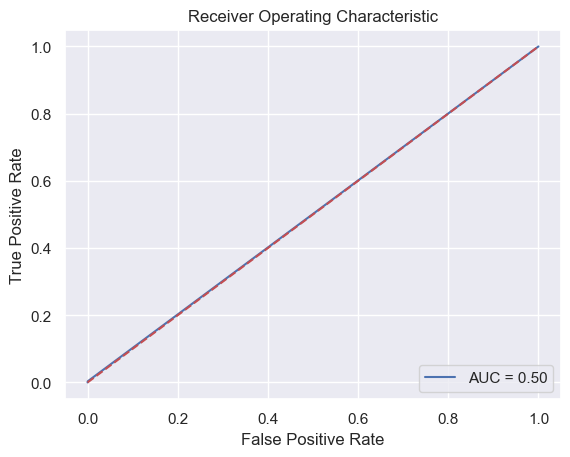

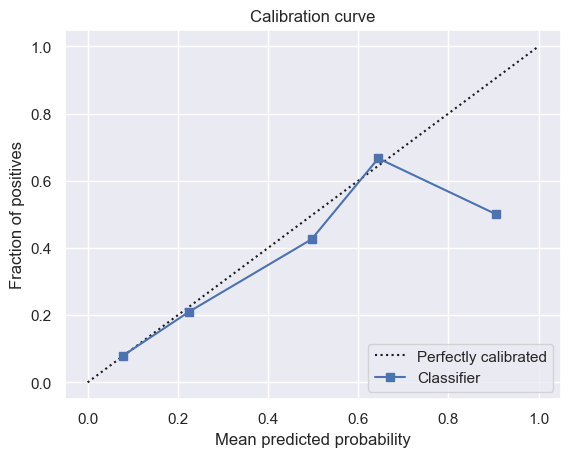

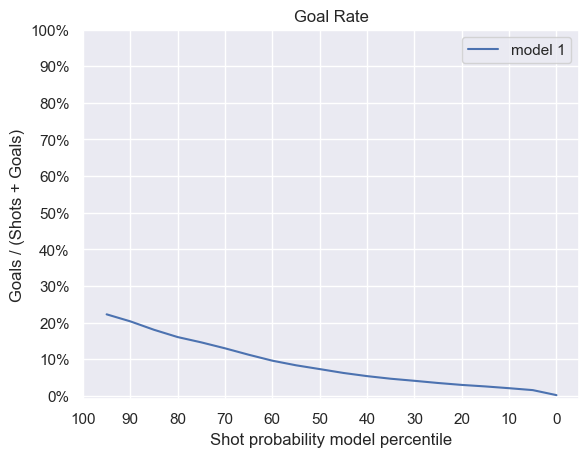

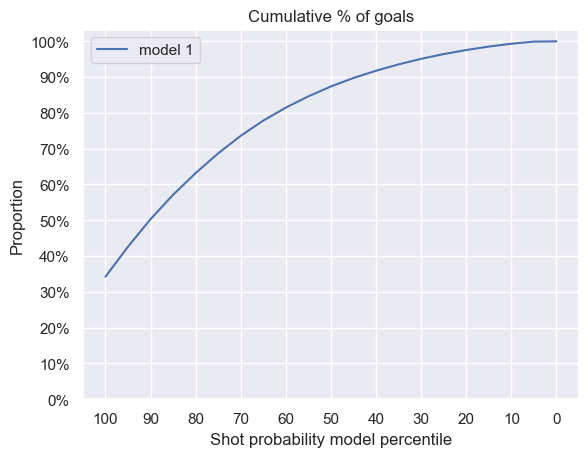

In [30]:
load_dotenv()

import os
experiment = Experiment(
        api_key=os.environ.get('COMET_API_KEY'),
        project_name='itf-6758-team-4',
        workspace='princesslove',
    )
log_All(y_val,y_val_pred,y_val_prob,experiment)

In [31]:
# question 5.2

list_features = ['empty_net', 'periodTime','period', 'x_coord', 'y_coord','distance','angle','shot_type',\
    'last_event_type', 'last_x_coord', 'last_y_coord','distance_from_last', 'seconds_since_last', \
        'rebound', 'angle_change','speed']

# preprocess
X, Y ,df_train_preprocessed =  preprocess(df_train,features = list_features, standarize=True)

# train/test split
X_train, X_val, y_train, y_val = train_test_split(X,Y,random_state = 42, shuffle=True)

# define and train model
model = XGBClassifier()

# fit_model
model.fit(X_train,y_train)
y_val_pred,y_val_prob = predict_model(model,X_val)

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/princesslove/itf-6758-team-4/80863eaa1d5a467bb2444f694f1c0b5d
COMET INFO:   Metrics:
COMET INFO:     AUC       : 0.5015114230541676
COMET INFO:     Accuracy  : 0.9064813547512101
COMET INFO:     Precision : 0.6775440646898974
COMET INFO:     Recall    : 0.5015114230541676
COMET INFO:     f_score   : 0.47890068739000086
COMET INFO:   Parameters:
COMET INFO:     begin_iteration : 0
COMET INFO:     copy            : True
COMET INFO:     end_iteration   : 99
COMET INFO:     objective       : binary:logistic
COMET INFO:     rank            : 0
COMET INFO:     with_mean       : True
COMET INFO:     with_std        : True
COMET INFO:     world_size      : 1
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-inf

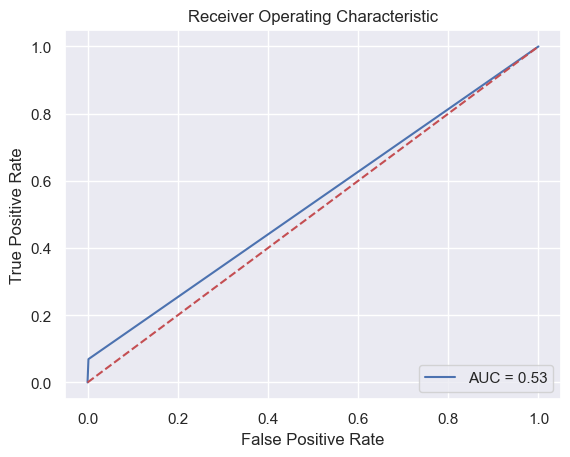

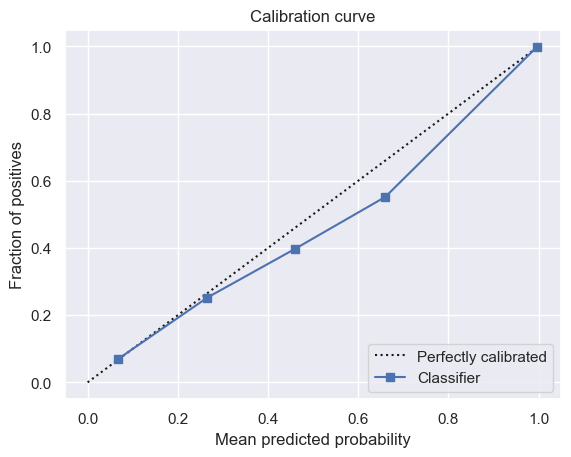

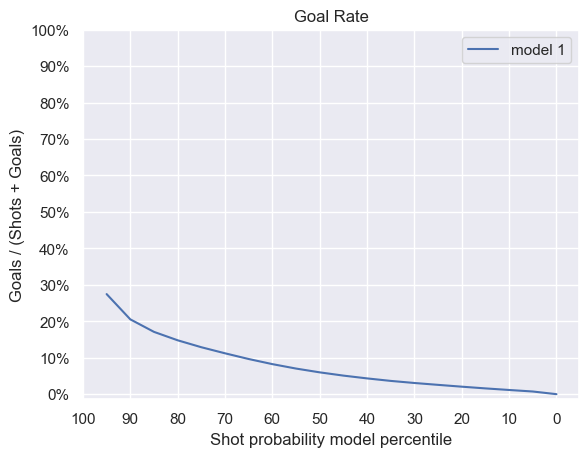

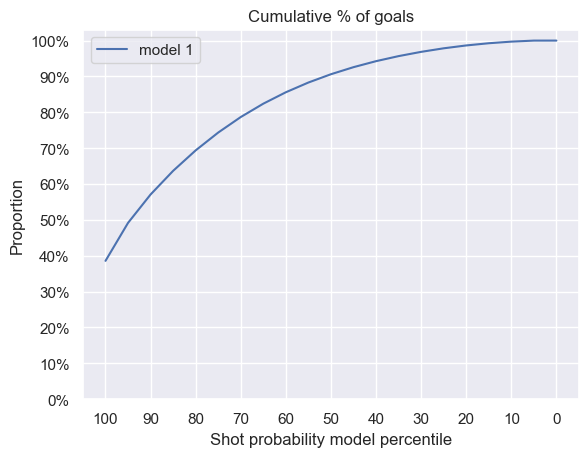

In [32]:

load_dotenv()

import os
experiment = Experiment(
        api_key=os.environ.get('COMET_API_KEY'),
        project_name='itf-6758-team-4',
        workspace='princesslove',
    )
log_All(y_val,y_val_pred,y_val_prob,experiment)